In [16]:
import glob

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

import data as data_class
import wifi_label_utils

In [17]:

def annotate(filename, label, avg_window_len, avg_duration=-1, debug=False):
    
    data_obj = data_class.Data(filename)

    # use a seconds worth of data to calculate threshold
    if avg_duration > -1:
        iq_samples = data_obj.get_samples(n_samples=int(data_obj.metadata["global"]["core:sample_rate"]*avg_duration))
    else:
        iq_samples = data_obj.get_samples()
        
    avg_pwr = wifi_label_utils.moving_average(iq_samples, avg_window_len)
    avg_pwr_db = 10*np.log10(avg_pwr)

    
    guess_threshold_old = (np.max(avg_pwr_db) + np.mean(avg_pwr_db))/2
    guess_threshold_old = 1.05 * np.max(avg_pwr_db)

    #MAD estimator

    # print(f"{np.quantile(avg_pwr_db, 0.75)=}")
    def median_absolute_deviation(series):
        # print(f"{np.median(series)=}")
        # print(np.abs(series-np.median(series)))
        # print(np.median(np.abs(series - np.median(series))))
        mad = 1.4826 * np.median(np.abs(series - np.median(series)))
        # print(f"{mad=}")
        # sci_mad = scipy.stats.median_abs_deviation(series, scale="normal")
        # print(f"{sci_mad=}")
        return np.median(series) + 6*mad

    mad = median_absolute_deviation(avg_pwr_db)
    guess_threshold = mad
    
    if debug:
        print(f"{np.max(avg_pwr_db)=}")
        print(f"{np.mean(avg_pwr_db)=}")
        print(f"median absolute deviation threshold = {mad}")
        print(f"{guess_threshold=}")
        print(f"{len(avg_pwr_db)=}")
        
        plt.figure()
        #plt.plot(avg_pwr_db[int(0*20480000e-2):int(avg_duration*20.48e6)])
        # db_plot = avg_pwr_db[int(0*20.48e6):int(avg_duration*20.48e6)]
        db_plot = avg_pwr_db[int(3.06*20.48e6):int(3.08*20.48e6)]
        # print(f"{len(db_plot)=}")
        plt.plot(db_plot)
        plt.axhline(y = guess_threshold_old, color = 'g', linestyle = '-') 
        plt.axhline(y = np.mean(avg_pwr_db), color = 'r', linestyle = '-') 
        plt.axhline(y = mad, color = 'b', linestyle = '-') 
        plt.show()
        
    wifi_label_utils.annotate_power_squelch(data_obj, label, guess_threshold, avg_window_len, skip_validate=True)


  0%|                                                                          | 0/24 [00:00<?, ?it/s]


Loaded 
 Data file: data/gamutrf/gamutrf-wifi-and-anom-bladerf/wifi-encoding-6-sendsps-5000000.s16.zst.sigmf-data 
 SigMF-Meta file: data/gamutrf/gamutrf-wifi-and-anom-bladerf/wifi-encoding-6-sendsps-5000000.s16.zst.sigmf-meta

np.max(avg_pwr_db)=-43.5547004826435
np.mean(avg_pwr_db)=-60.8460210360527
median absolute deviation threshold = -58.545539819975104
guess_threshold=-58.545539819975104
len(avg_pwr_db)=81919745


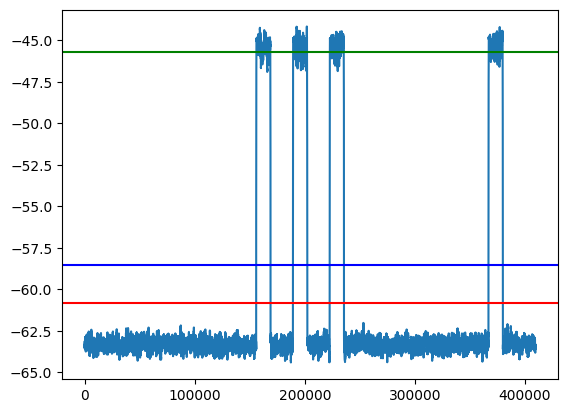

  0%|                                                                          | 0/24 [00:57<?, ?it/s]


In [15]:
for f in tqdm(glob.glob("data/gamutrf/gamutrf-wifi-and-anom-bladerf/wifi*.sigmf-meta")):
    annotate(f, label="wifi", avg_window_len=256, avg_duration=4, debug=True)
    break
    
# for f in tqdm(glob.glob("data/gamutrf/gamutrf-wifi-and-anom-bladerf/anom*.sigmf-meta")):
#     annotate(f, label="anom_wifi", avg_window_len=256, avg_duration=4, debug=True)

